In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import requests

## Test requests

In [2]:
URL = "http://localhost:8003/seldon/seldon/v2-triton-mnist"


def predict(data):
    data = {
        "inputs": [
            {
                "name": "conv2d_input",
                "data": data.tolist(),
                "datatype": "FP32",
                "shape": data.shape,
            }
        ]
    }

    r = requests.post(f"{URL}/v2/models/mnist/infer", json=data)
    predictions = np.array(r.json()["outputs"][0]["data"]).reshape(
        r.json()["outputs"][0]["shape"]
    )
    output = [np.argmax(x) for x in predictions]
    return output


In [3]:
(_, _), (X_test, y_test) = mnist.load_data()

X_test = X_test.reshape(-1, 28, 28, 1)
X_test = X_test.astype("float32")
X_test /= 255

Y_test = to_categorical(y_test, 10)

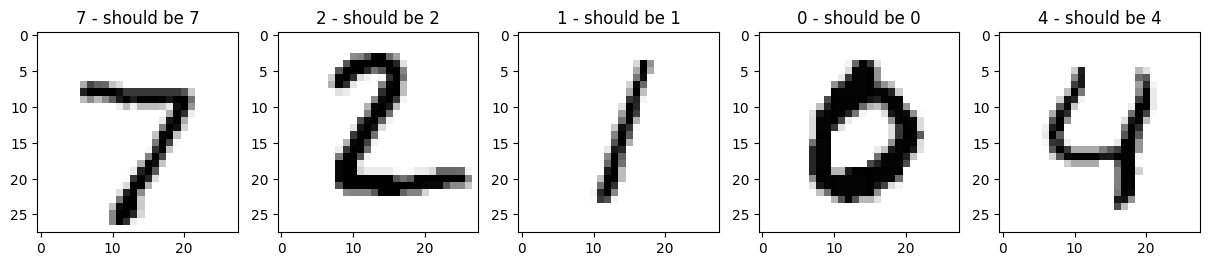

In [4]:
predictions = predict(X_test[:5])
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axs[i].imshow(X_test[i, :, :, 0], cmap="binary")
    axs[i].set_title("{} - should be {}".format(predictions[i], np.argmax(Y_test[i])))

## Test Triton Client

In [5]:
import tritonclient.http as httpclient

url = "localhost:8003/seldon/seldon/v2-triton-mnist"

triton_client = httpclient.InferenceServerClient(
    url=url,
    verbose=False,
    concurrency=1,
)

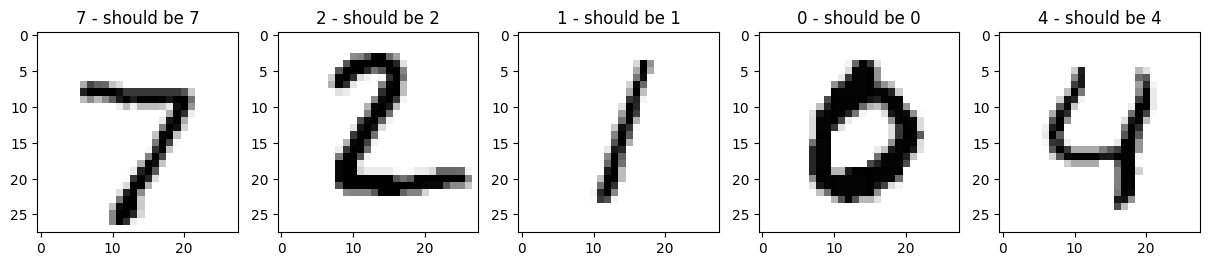

In [6]:
binary_data = False

inputs = [httpclient.InferInput("conv2d_input", (5, 28, 28, 1), "FP32")]
inputs[0].set_data_from_numpy(X_test[:5], binary_data=binary_data)
outputs = [httpclient.InferRequestedOutput("dense_1", binary_data=binary_data)]

result = triton_client.infer("mnist", inputs, outputs=outputs)
predictions = [np.argmax(x) for x in result.as_numpy("dense_1")]

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axs[i].imshow(X_test[i, :, :, 0], cmap="binary")
    axs[i].set_title("{} - should be {}".format(predictions[i], np.argmax(Y_test[i])))